In [66]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [67]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import scipy as sp
from scipy import signal
import os
from eofs.xarray import Eof
from eofs.standard import Eof as EofStandard
from eofs.multivariate.standard import MultivariateEof
import regionmask

In [68]:
# first load your data

dirn = '/global/scratch/medhap02/ISMData/'
filen = 'chirps-v2.0.monthly.nc'
datgpcp = xr.open_dataset(dirn+filen)#,chunks={'latitude': 200, 'longitude': 600, 'time': -1})
# precip units are mm/day:
prgpcp = datgpcp['precip']
prgpcp = prgpcp.rename({
    "latitude": "lat",
    "longitude": "lon"
})
print(prgpcp)
# select years of interest (dataset only goes thru march 2019):
prgpcp = prgpcp.sel(time=slice('1981-01-01','2018-12-31'))

<xarray.DataArray 'precip' (time: 473, lat: 2000, lon: 7200)>
[6811200000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -49.975 -49.925 -49.875 ... 49.924995 49.975
  * lon      (lon) float32 -179.975 -179.925 -179.875 ... 179.92499 179.975
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2020-05-01
Attributes:
    units:               mm/month
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           month
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0


In [69]:
#(5-35n, 65-95e)
latlim1 = 5
latlim2 = 35
lonlim1 = 65
lonlim2 = 95

# take seasonal mean and select latitudes to use in analysis:
prgpcpSubset = prgpcp.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))

def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcpSubset.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean())

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")

# subtract time mean from each data point (EOFs work with anomalies)
tmppr = prgpcpSeas - prgpcpSeas.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'
tmppr

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'precip' (year: 38, lat: 600, lon: 600)>
array([[[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [-8.809966e-02, -9.043300e-02, ...,  1.101169e+01,  1.249266e+01],
        [-8.262575e-02, -8.744615e-02, ...,  1.487557e+01,  1.421708e+01]],

       [[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [-2.350271e-03, -3.692269e-03, ...,  2.045258e+00,  2.737705e+00],
        [ 1.354033e-02,  6.737590e-03, ...,  4.782204e+00,  3.396732e+00]],

       ...,

       [[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [-5.314988e-02, -5.512911e-02, ...,  1.042258e+01,  8.433712e+00],
        [-3.718805e-02, -4.302877e-02, ...,  8.840233e+00,  

In [70]:
# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)
tmppr2.load()
coslat2.load()
#print(tmppr2)
#print(coslat2)
# find the EOFs
#solver_prfull = EofStandard(tmppr.data,weights=coslat2.data,center=True)
solver_prfull = Eof(tmppr2,weights=coslat2,center=True)
pcs_prfull = solver_prfull.pcs()
eofs_prfull = solver_prfull.eofs()
varfrac_prfull = solver_prfull.varianceFraction()

In [71]:
latlim1 = 5
latlim2 = 38
lonlim1 = 65
lonlim2 = 99

prgpcpSub = prgpcp.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))

# take seasonal mean and select latitudes to use in analysis:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(prgpcpSub)
India_index = regionmask.defined_regions.natural_earth.countries_110.map_keys("India")
prgpcpSubset = prgpcpSub.where(mask == India_index)

In [72]:
def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcpSubset.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean())

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")

# subtract time mean from each data point (EOFs work with anomalies)
precip_India = prgpcpSeas - prgpcpSeas.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
precip_India.year.attrs['axis'] = 'T'
precip_India

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'precip' (year: 38, lat: 660, lon: 680)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 5.0249977 5.074997 5.125 ... 37.875 37.924995 37.975
  * lon      (lon) float32 65.024994 65.075 65.125 ... 98.875 98.92499 98.975006
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2014 2015 2016 2017 2018

In [92]:
# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(precip_India.lat*np.pi/180)
precip_India2, coslat2 = xr.broadcast(precip_India, coslat)
precip_India2.load()
coslat2.load()
India_solver_pr = Eof(precip_India2,weights=coslat2,center=True)
India_pcs_pr = India_solver_pr.pcs()
India_eofs_pr = India_solver_pr.eofs()
India_varfrac_pr = India_solver_pr.varianceFraction()

# plot results

sum of variance in first 4 pr EOFs =  0.5396519
total anomaly variance pr = 336159460.0


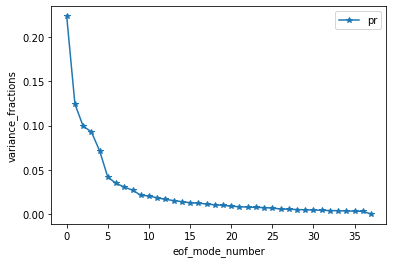

In [74]:
varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_prfull.totalAnomalyVariance())

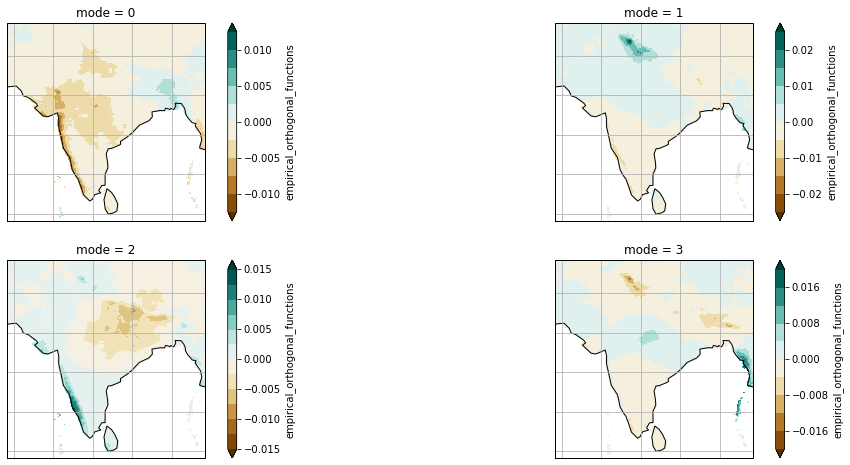

In [96]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_prfull[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

In [76]:
levels=np.linspace(-360, 360, 13)

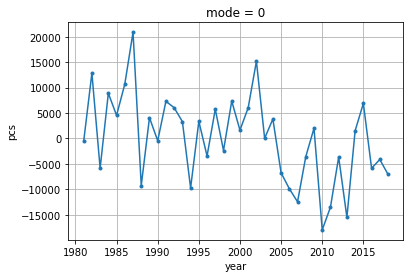

In [77]:
pcs_prfull.sel(mode=0).plot(marker='.')
plt.grid()

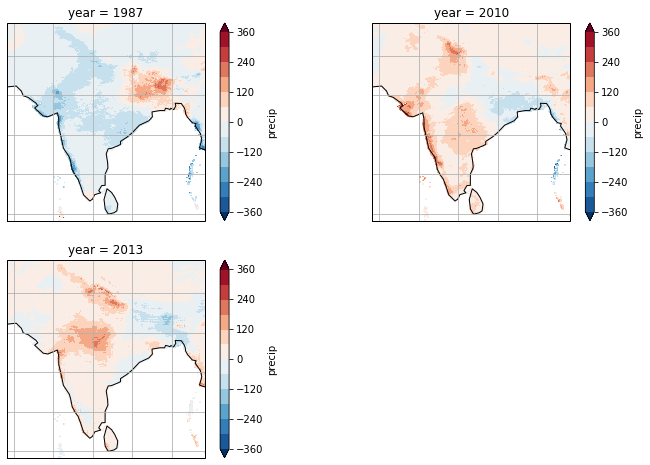

In [78]:
pcs_prfull.sel(mode=0)
mode0 = [6, 29, 32]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

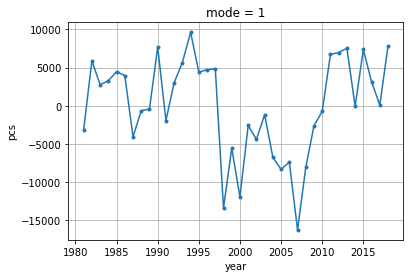

In [79]:
pcs_prfull.sel(mode=1).plot(marker='.')
plt.grid()

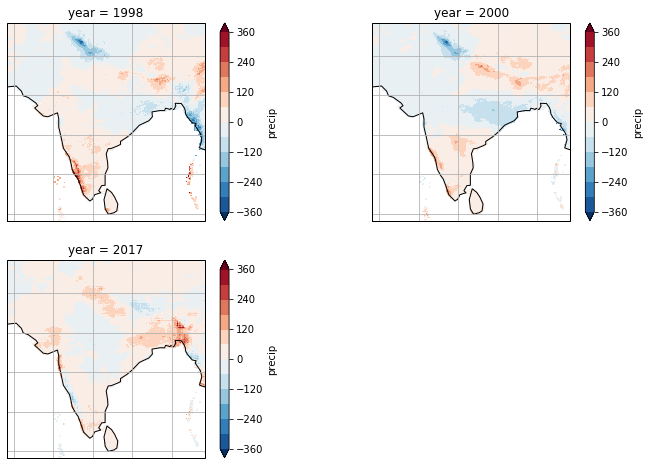

In [80]:
pcs_prfull.sel(mode=1)
mode1 = [17, 19, 36]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode1[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

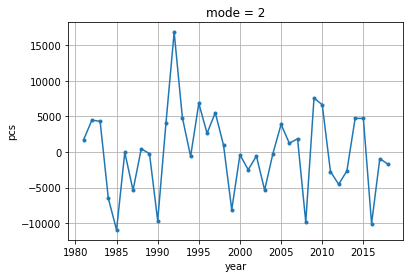

In [81]:
pcs_prfull.sel(mode=2).plot(marker='.')
plt.grid()

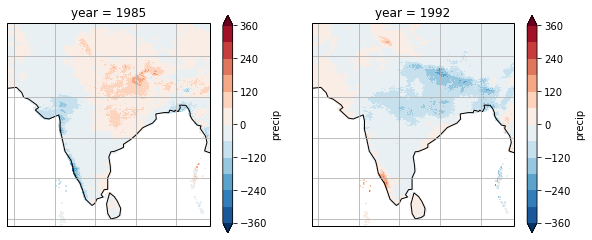

In [82]:
pcs_prfull.sel(mode=2)
mode2 = [4, 11]
plt.figure(figsize=(10,4))
for i in np.arange(0,2):
    ax = plt.subplot(1,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode2[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

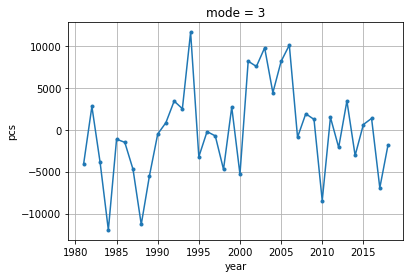

In [83]:
pcs_prfull.sel(mode=3).plot(marker='.')
plt.grid()

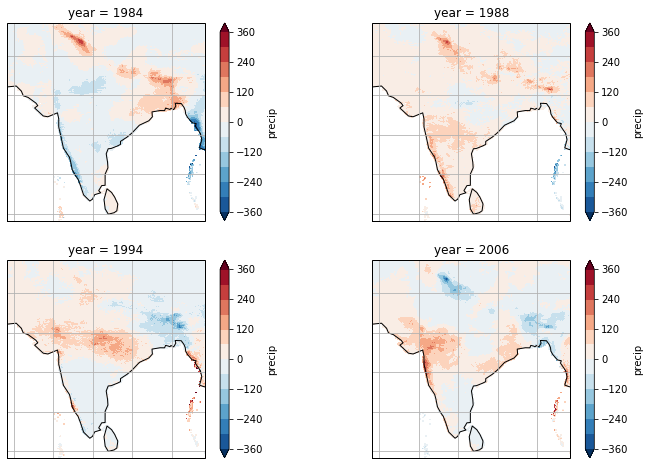

In [84]:
pcs_prfull.sel(mode=3)
mode3 = [3, 7, 13, 25]
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode3[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

# correlation with AIRI

In [85]:
dirn = '/global/scratch/medhap02/ISMData/'
filen = 'pALLIN.nc'
airi_dat = xr.open_dataset(dirn+filen, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
precip = airi_dat['precip']

precipfull = precip.sel(time=slice('1981-01-01','2016-12-31'))

In [86]:
def is_summer(month):
    return (month >= 6) & (month <= 9)
precip_subset = precipfull.sel(time=is_summer(precipfull['time.month']))#.groupby('time.year').mean()


precip_subset = precip_subset.groupby('time.year',restore_coord_dims = True).sum("time")
#print(precip_subset.dims)

#print(precip_subset)

precip_jjas = precip_subset - precip_subset.mean(dim='year')

print(precip_jjas)

<xarray.DataArray 'precip' (year: 36)>
array([  -6.069458,  -53.469482,   41.53058 ,   14.930542,  -62.06952 ,
        -45.26947 , -113.869446,   87.93054 ,   25.130554,  108.130554,
         21.930542,   -4.569519,  -29.569519,  129.53058 ,   10.23053 ,
         18.030518,    9.73053 ,  -28.76947 ,   -6.569458,   22.130554,
         20.73053 , -144.06946 ,   -9.969482,  -17.76947 ,  -47.76947 ,
         97.330505,   58.930542,   36.630554, -114.76947 ,   30.23053 ,
         37.43048 ,  -70.76947 ,  124.03052 ,  -87.26947 ,  -70.26947 ,
         18.330505], dtype=float32)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2012 2013 2014 2015 2016


In [87]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [97]:
pcs_pr = pcs_prfull.sel(year=slice('1980', '2016'))
corr0 = correlation(pcs_pr.sel(mode=0), precip_jjas, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(pcs_pr.sel(mode=3), precip_jjas, dims='year')
print("chirps (1981 - 2016)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

chirps (1981 - 2016)
mode 0:  -0.6509609497626304
mode 1:  0.11051252886113115
mode 2:  -0.1348286628085125
mode 3:  0.03229558309683794


# regionmask India

sum of variance in first 4 pr EOFs =  0.61032355
total anomaly variance pr = 239972030.0


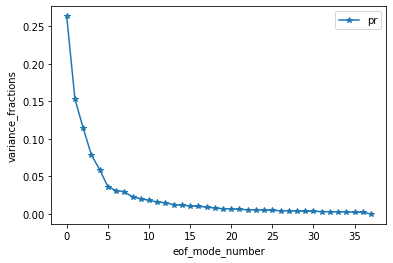

In [98]:
India_varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', India_varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', India_solver_prfull.totalAnomalyVariance())

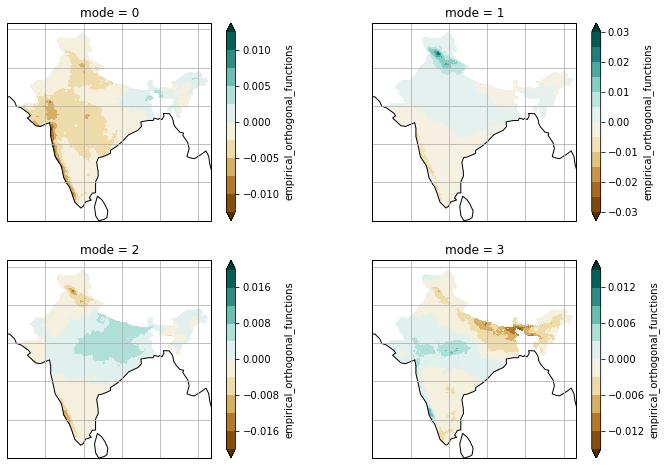

In [101]:
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    India_eofs_pr[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([66,98,6,37],crs=ccrs.PlateCarree())

In [100]:
pcs_pr = India_pcs_prfull.sel(year=slice('1980', '2016'))

corr0 = correlation(pcs_pr.sel(mode=0), precip_jjas, dims='year')
corr1 = correlation(pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(pcs_pr.sel(mode=3), precip_jjas, dims='year')

print("India chirps (1981 - 2016)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

India chirps (1981 - 2016)
mode 0:  -0.6613940530607737
mode 1:  0.07060756923991976
mode 2:  0.16525588125763221
mode 3:  0.025372158331073938


In [ ]:
 # Copyright (c) 2020 Medha Palavalli.